# Explore the 000 Model Run

In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
# colormaps = https://matplotlib.org/cmocean/
import cmocean
import matplotlib.pyplot as plt
import geopandas as gpd
from typing import List, Tuple, Dict, Union, Optional

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

import os

# set the working directory
current_path = Path('.').resolve()
if current_path == Path('/home/tommy/ml_drought/notebooks/draft'):
    os.chdir(current_path.parents[1].as_posix())

current_path = Path('.').resolve()
assert current_path.name == "ml_drought"

%load_ext autoreload
%autoreload 2

In [2]:
from scripts.utils import get_data_path
from src.engineer import Engineer

In [3]:
from src.utils import get_ds_mask

data_dir = get_data_path()

# Model Run

In [4]:
from src.analysis import read_train_data, read_test_data, read_pred_data
from scripts.analysis import read_all_data, read_all_available_pred_data, load_nn, create_all_error_metrics

In [5]:
experiment = "one_month_forecast"
[d.name for d in (data_dir / f"models/{experiment}").iterdir()]

['previous_month', 'rnn', 'ealstm']

In [6]:
# read train/test data
# X_train, y_train, X_test, y_test = read_all_data(
#     data_dir, static=False, experiment=experiment
# )

X_train = xr.open_dataset(data_dir / "000_models/one_month_forecast/X_train.nc")
y_train = xr.open_dataset(data_dir / "000_models/one_month_forecast/y_train.nc")
X_test = xr.open_dataset(data_dir / "000_models/one_month_forecast/X_test.nc")
y_test = xr.open_dataset(data_dir / "000_models/one_month_forecast/y_test.nc")

mask = get_ds_mask(X_train.VCI)
test_da = y_test[list(y_test.data_vars)[0]]

In [7]:
# read the predicted data
# predictions = read_all_available_pred_data(data_dir, experiment=experiment)

predictions = {}
for model in ["previous_month", "linear_network", "rnn"]:
    da = xr.open_dataset(data_dir / f"000_models/one_month_forecast/{model}_preds.nc")
    predictions[model] = da[[v for v in da.data_vars][0]]

#  check that the shapes of all predictions are the same
assert set([predictions[m].shape for m in predictions.keys()]).__len__() == 1
preds = predictions[list(m for m in predictions.keys())[0]]

# get the matching shapes from predictions and test data
test_da = test_da.sel(lat=preds.lat, lon=preds.lon, time=preds.time)

### Calculate Error Metrics

In [8]:
rmse_dict, r2_dict = create_all_error_metrics(predictions, test_da)

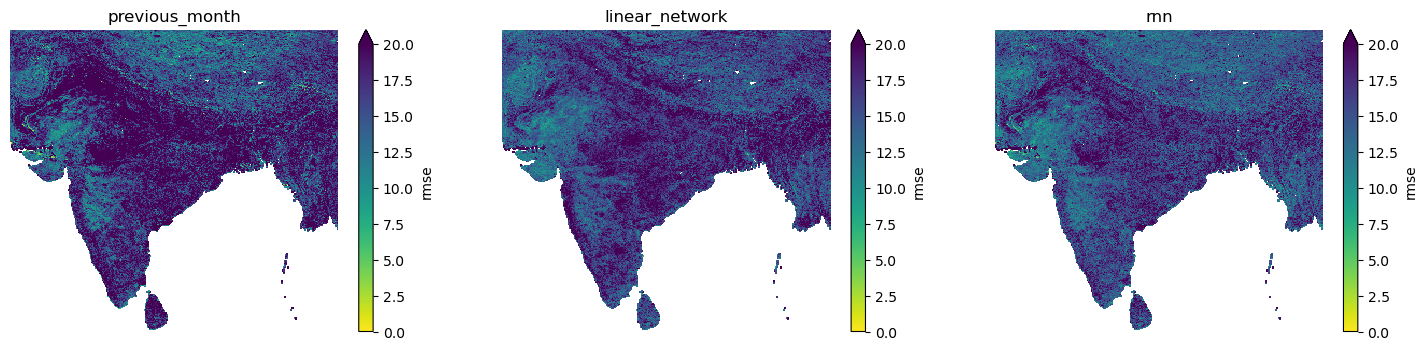

In [9]:
kwargs = dict(vmin=0, vmax=20, cmap="viridis_r")

fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, key in enumerate(rmse_dict.keys()):
    ax = axs[i]
    rmse_dict[key].plot(ax=ax, **kwargs)
    ax.set_title(str(key))  
    ax.axis('off')

# Join Metrics to Region DataFrame

In [10]:
l1_gdf = gpd.read_file(data_dir / "raw/boundaries/india/IND_adm1.shp")
l2_gdf = gpd.read_file(data_dir / "raw/boundaries/india/IND_adm2.shp")

l1_mask = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/state_l1_india.nc")
l2_mask = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/district_l2_india.nc")

l1_lookup = dict(zip(
    [int(k.lstrip().rstrip()) for k in l1_mask.attrs["keys"].split(',')], 
    [k.lstrip().rstrip() for k in l1_mask.attrs["values"].split(',')]
))
l2_lookup = dict(zip(
    [int(k.lstrip().rstrip()) for k in l2_mask.attrs["keys"].split(',')], 
    [k.lstrip().rstrip() for k in l2_mask.attrs["values"].split(',')]
))

### Creating the R2/RMSE GeoDataFrames

In [11]:
from scripts.analysis import create_metric_gdf

In [12]:
## -- Level 1 --
l1_rmse_gdf = create_metric_gdf(
    metric_dict=rmse_dict,
    region_gdf=l1_gdf,
    gdf_name_col="NAME_1",
    region_mask=l1_mask,
)

l1_r2_gdf = create_metric_gdf(
    metric_dict=r2_dict,
    region_gdf=l1_gdf,
    gdf_name_col="NAME_1",
    region_mask=l1_mask,
)


## -- Level 2 --
l2_rmse_gdf = create_metric_gdf(
    metric_dict=rmse_dict,
    region_gdf=l2_gdf,
    gdf_name_col="NAME_2",
    region_mask=l2_mask,
)

l2_r2_gdf = create_metric_gdf(
    metric_dict=r2_dict,
    region_gdf=l2_gdf,
    gdf_name_col="NAME_2",
    region_mask=l2_mask,
)

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis,

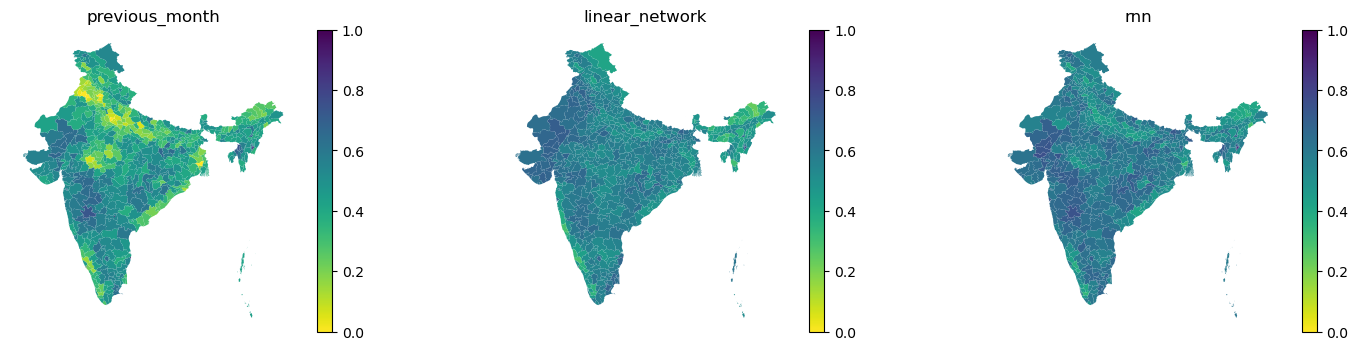

In [13]:
kwargs = {"vmin": 0, "vmax": 1, "cmap": "viridis_r"}

fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, model in enumerate([c for c in l2_r2_gdf.columns if c not in ["region_name", "geometry", "index"]]):
    ax = axs[i]
    l2_r2_gdf.plot(model, legend=True, ax=ax, **kwargs)
    ax.set_title(model)
    
    ax.axis('off')

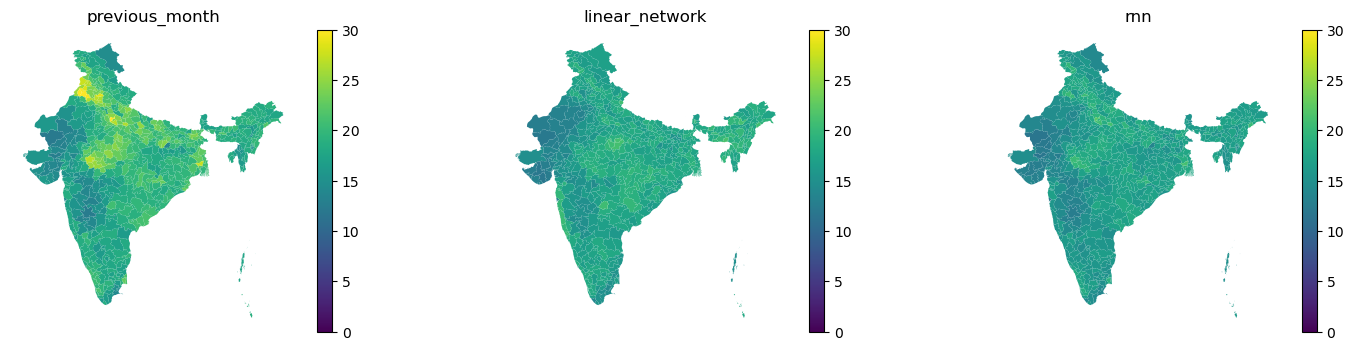

In [14]:
kwargs = {"vmin": 0, "vmax": 30, "cmap": "viridis"}

fig, axs = plt.subplots(1, 3, figsize=(6*3, 4))
for i, model in enumerate([c for c in l2_r2_gdf.columns if c not in ["region_name", "geometry", "index"]]):
    ax = axs[i]
    l2_rmse_gdf.plot(model, legend=True, ax=ax, **kwargs)
    ax.set_title(model)
    
    ax.axis('off')

# Admin Regions

In [15]:
from scripts.analysis import AdministrativeRegionAnalysis

In [16]:
# run_administrative_region_analysis()
analyzer = AdministrativeRegionAnalysis(data_dir)

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['previous_month', 'rnn', 'ealstm']
Regions: ['state_l1_india.nc', 'district_l2_india.nc']
Region Type: administrative_boundaries


In [17]:
dir(analyzer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_analyze_single',
 '_base_analyze_single',
 'admin_boundaries',
 'analyze',
 'compute_error_metrics',
 'compute_global_error_metrics',
 'compute_mean_statistics',
 'compute_metrics',
 'compute_regional_error_metrics',
 'create_model_performance_by_region_geodataframe',
 'data_dir',
 'df',
 'experiment',
 'features_dir',
 'get_pred_data_on_timestep',
 'load_prediction_data',
 'load_region_data',
 'load_true_data',
 'models',
 'models_dir',
 'out_dir',
 'pred_variable',
 'read_xr_datetime',
 'region_data_paths',
 'shape_data_dir',
 'true_variable']

[PosixPath('/cats/datastore/data/analysis/boundaries_preprocessed/district_l2_india.nc')]

In [ ]:
analyzer.analyze()

In [ ]:
region_df = analyzer.df

In [ ]:
l1_ts_gdf = gpd.GeoDataFrame(
    region_df[region_df.admin_level_name == "state_l1_india"]
    .sort_values(["model", "datetime"])
    .set_index("region_name")
    .join(l1_gdf[["NAME_1", "geometry"]].set_index("NAME_1"))
    .reset_index()
)

l2_ts_gdf = gpd.GeoDataFrame(
    region_df[region_df.admin_level_name == "district_l2_india"]
    .sort_values(["model", "datetime"])
    .set_index("region_name")
    .join(l2_gdf[["NAME_2", "geometry"]].set_index("NAME_2"))
    .reset_index()
)

In [ ]:
l1_ts_gdf

In [ ]:
X_train, y_train, X_test, y_test

In [ ]:
for model, da in predictions.items():
    da.to_netcdf(data_dir / f"000_models/one_month_forecast/{model}_preds.nc")